In [230]:
import numpy as np
from scipy import sparse
from os import listdir
from scipy.stats import chi2_contingency, fisher_exact
import matplotlib.pyplot as plt

data_dir = '../split_gen_miss'
ped_file = '../data/160826.ped'
pvalue_dir = '../parental_differences_ihart'

bonferonni_cutoff = 11
chroms = [str(x) for x in range(1, 23)]

In [231]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}


# GWAS for sex (M/F) on the autosomal chromosomes

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

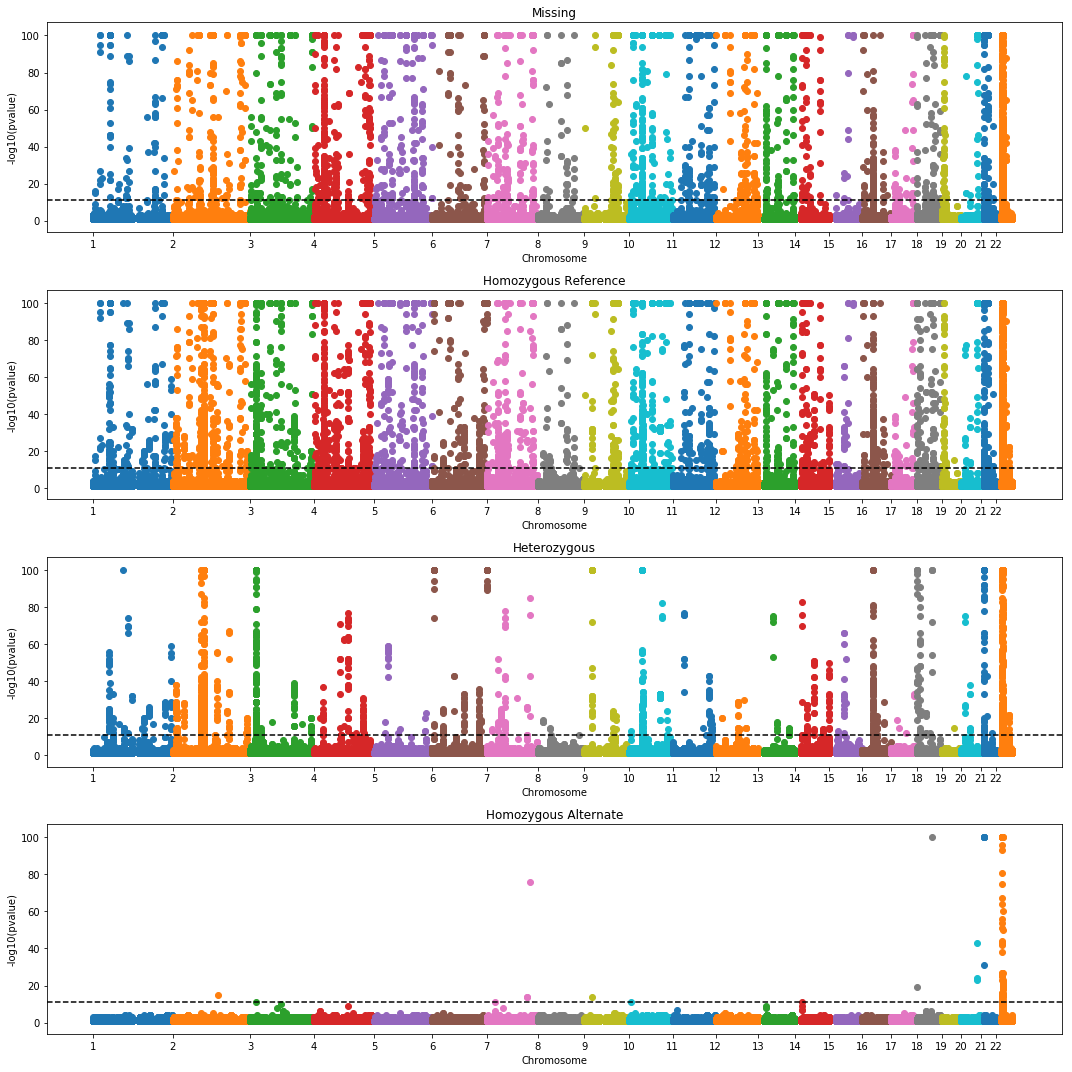

In [243]:
plt.figure(figsize=(15, 15))
offsets = [0]
for chrom in chroms:
    print(chrom, end=' ')
    
    # pull snp positions
    pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
    snp_positions = pos_data[:, 1]
    is_snp = pos_data[:, 2].astype(bool)
    snp_positions = snp_positions[is_snp]
    
    # pull log pvalues
    log_pvalues = np.load('%s/chr.%s.logpvalues.npy' % (pvalue_dir, chrom))
    log_pvalues[log_pvalues>100] = 100
    
    for i in range(4):
        # nonzero indices
        indices = log_pvalues[:, i] != 0

        plt.subplot(4, 1, i+1)
        plt.scatter(snp_positions[indices]+offsets[-1], log_pvalues[indices, i])
    
    offsets.append(offsets[-1]+chrom_lengths[chrom])

titles = ['Missing', 'Homozygous Reference', 'Heterozygous', 'Homozygous Alternate']
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.xticks(offsets[:-1], chroms)
    plt.xlabel('Chromosome')
    plt.ylabel('-log10(pvalue)')
    plt.title(titles[i])
    plt.axhline(bonferonni_cutoff, color='black', linestyle='--')

plt.tight_layout()
plt.show()

# Now look at genotypes at these positions

In [244]:
# pull indices of moms, dads, daughters, and sons

mom_indices, dad_indices = set(), set()
daughter_indices, son_indices = set(), set()
autism_indices, noautism_indices = set(), set()

with open('%s/chr.%s.gen.samples.txt' % (data_dir, chrom), 'r') as f:
    sample_id_to_index = dict([(x.strip(), i) for i, x in enumerate(f)])
    
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 5:
            if pieces[5] == '2':
                if pieces[3] in sample_id_to_index:
                    mom_indices.add(sample_id_to_index[pieces[3]])
                if pieces[2] in sample_id_to_index:
                    dad_indices.add(sample_id_to_index[pieces[2]])
            if pieces[1] in sample_id_to_index:
                if pieces[4] == '2':
                    daughter_indices.add(sample_id_to_index[pieces[1]])
                elif pieces[4] == '1':
                    son_indices.add(sample_id_to_index[pieces[1]])
                if pieces[5] == '2':
                    autism_indices.add(sample_id_to_index[pieces[1]])
                elif pieces[5] == '1':
                    noautism_indices.add(sample_id_to_index[pieces[1]])

daughter_indices = daughter_indices - mom_indices
son_indices = son_indices - dad_indices

autism_indices = autism_indices & (daughter_indices | son_indices)
noautism_indices = noautism_indices & (daughter_indices | son_indices)

print('Moms', len(mom_indices), 'Dads', len(dad_indices))
print('Daughters', len(daughter_indices), 'Sons', len(son_indices))
print('Autism', len(autism_indices), 'No autism', len(noautism_indices))

Moms 996 Dads 896
Daughters 777 Sons 1927
Autism 2179 No autism 525


In [225]:
# now pull genotypes for sites of interest

positions_of_interest, gens_of_interest = [], []
for chrom in chroms:
    print(chrom)
    
    # pull snp positions
    pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
    snp_positions = pos_data[:, 1]
    is_snp = pos_data[:, 2].astype(bool)
    
    # pull log pvalues
    log_pvalues = np.load('%s/chr.%s.logpvalues.npy' % (pvalue_dir, chrom))
    print(log_pvalues.shape)

    gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])
    offset_raw, offset_updated = 0, 0
    for gen_file in gen_files:
        print(gen_file)
        A = sparse.load_npz('%s/%s' % (data_dir, gen_file))
        m, n = A.shape
        local_snp_positions = snp_positions[offset_raw:(offset_raw+n)]
        
        # filter out snps
        A = A[:, is_snp[offset_raw:(offset_raw+n)]]
        local_snp_positions = local_snp_positions[is_snp[offset_raw:(offset_raw+n)]]
        offset_raw += n
        m, n = A.shape
        
        A[A<-1] = -1
        
        indices_of_interest = np.any(log_pvalues[offset_updated:(offset_updated+n)] > bonferonni_cutoff, axis=1)
        positions_of_interest.extend([(chrom, p) for p in local_snp_positions[indices_of_interest]])
        gens_of_interest.append(A[:, indices_of_interest].A)
        
        offset_updated += n
    
gens_of_interest = np.hstack(gens_of_interest)
m, n = gens_of_interest.shape
print(len(positions_of_interest), m, n)

1
(5734832, 4)
chr.1.0.gen.npz
chr.1.1.gen.npz
chr.1.2.gen.npz
chr.1.3.gen.npz
2
(6130682, 4)
chr.2.0.gen.npz
chr.2.1.gen.npz
chr.2.2.gen.npz
chr.2.3.gen.npz
791 4610 791


In [227]:
#remove_chrom2 = [chrom!='2' for chrom, pos in positions_of_interest]
#gens_of_interest_new = gens_of_interest[:, remove_chrom2]
#positions_of_interest_new = [(chrom, pos) for chrom, pos in positions_of_interest if chrom!='2']

gens_of_interest = np.hstack((gens_of_interest, gens_of_interest_new))
m, n = gens_of_interest.shape
positions_of_interest = positions_of_interest + positions_of_interest_new
print(len(positions_of_interest), gens_of_interest.shape)

4774 (4610, 4774)


In [228]:
print(m, n)

4610 4774


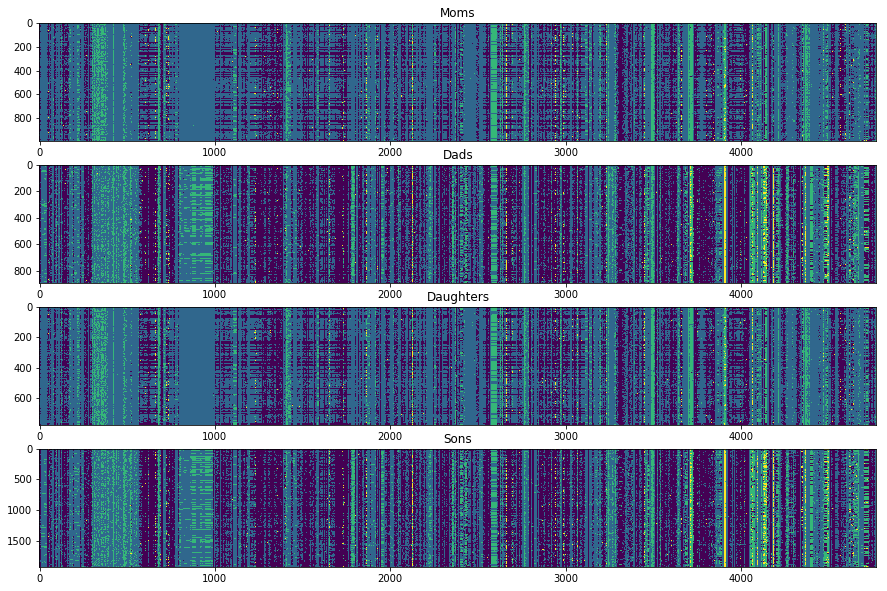

In [253]:
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.imshow(gens_of_interest[list(mom_indices)], aspect='auto')
plt.title('Moms')

plt.subplot(4, 1, 2)
plt.imshow(gens_of_interest[list(dad_indices)], aspect='auto')
plt.title('Dads')

plt.subplot(4, 1, 3)
plt.imshow(gens_of_interest[list(daughter_indices)], aspect='auto')
plt.title('Daughters')

plt.subplot(4, 1, 4)
plt.imshow(gens_of_interest[list(son_indices)], aspect='auto')
plt.title('Sons')

plt.show()

# Now run a GWAS for autism at these sites

In [170]:
def calc_pvalue(dc):        
    if np.all(dc>5):
        pvalue = chi2_contingency(dc, correction=True)[1]
        if pvalue == 0:
            logpvalue = 1000
        else:
            logpvalue = -np.log10(pvalue)
    elif (m==0 and d==0) or (m==num_moms and d==num_dads):
        logpvalue = 0
    else:
        pvalue = fisher_exact(dc)[1]
        if pvalue == 0:
            logpvalue = 1000
        else:
            logpvalue = -np.log10(pvalue)
    return logpvalue

In [249]:
autism_pvalues = np.zeros((n,), dtype=int)
for i in range(n):
    dc = np.asarray([[2*np.sum(gens_of_interest[list(autism_indices), i]==0) + np.sum(gens_of_interest[list(autism_indices), i]==1),
                     2*np.sum(gens_of_interest[list(autism_indices), i]==2) + np.sum(gens_of_interest[list(autism_indices), i]==1)],
                    [2*np.sum(gens_of_interest[list(noautism_indices), i]==0) + np.sum(gens_of_interest[list(noautism_indices), i]==1),
                     2*np.sum(gens_of_interest[list(noautism_indices), i]==2) + np.sum(gens_of_interest[list(noautism_indices), i]==1)]])
    #print(dc)
    autism_pvalues[i] = calc_pvalue(dc)
    
    
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

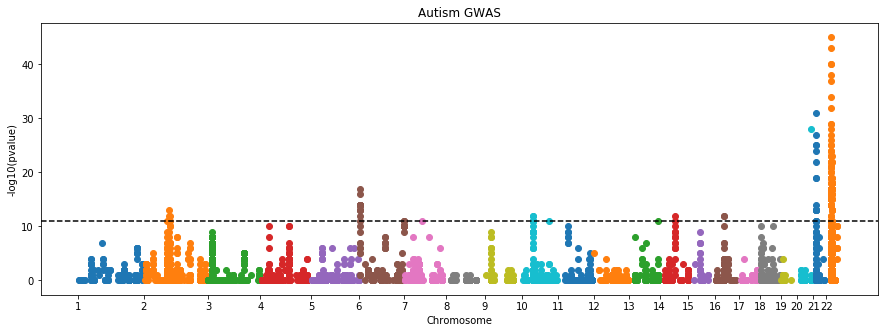

In [252]:
plt.figure(figsize=(15, 5))
offsets = [0]
for chrom in chroms:
    print(chrom, end=' ')
    
    # pull snp positions
    indices = [i for i, (c, pos) in enumerate(positions_of_interest) if c==chrom]
    pos_data = [positions_of_interest[i][1] for i in indices]
    
    # pull log pvalues
    log_pvalues = [autism_pvalues[i] for i in indices]
    plt.scatter([p+offsets[-1] for p in pos_data], log_pvalues)
    offsets.append(offsets[-1]+chrom_lengths[chrom])

plt.xticks(offsets[:-1], chroms)
plt.xlabel('Chromosome')
plt.ylabel('-log10(pvalue)')
plt.title('Autism GWAS')
plt.axhline(bonferonni_cutoff, color='black', linestyle='--')
plt.show()

156


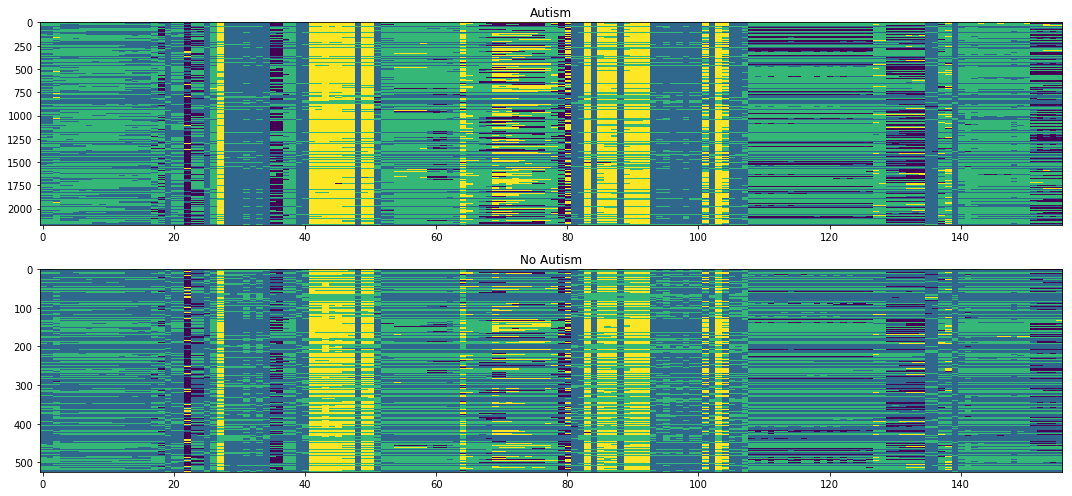

In [259]:
autism_gens_of_interest = gens_of_interest[:, autism_pvalues>bonferonni_cutoff]

plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.imshow(autism_gens_of_interest[list(autism_indices)], aspect='auto')
plt.title('Autism')

plt.subplot(2, 1, 2)
plt.imshow(autism_gens_of_interest[list(noautism_indices)], aspect='auto')
plt.title('No Autism')

print(np.sum(autism_pvalues>bonferonni_cutoff))
plt.tight_layout()
plt.show()

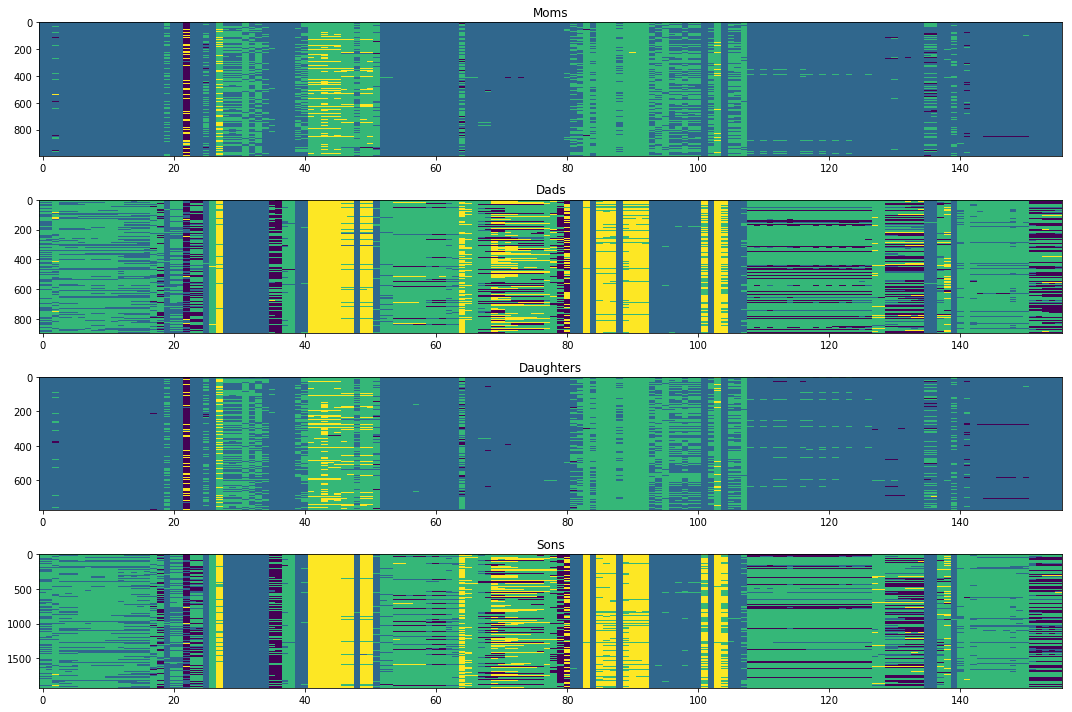

In [255]:
autism_gens_of_interest = gens_of_interest[:, autism_pvalues>bonferonni_cutoff]

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.imshow(autism_gens_of_interest[list(mom_indices)], aspect='auto')
plt.title('Moms')

plt.subplot(4, 1, 2)
plt.imshow(autism_gens_of_interest[list(dad_indices)], aspect='auto')
plt.title('Dads')

plt.subplot(4, 1, 3)
plt.imshow(autism_gens_of_interest[list(daughter_indices)], aspect='auto')
plt.title('Daughters')

plt.subplot(4, 1, 4)
plt.imshow(autism_gens_of_interest[list(son_indices)], aspect='auto')
plt.title('Sons')

plt.tight_layout()
plt.show()

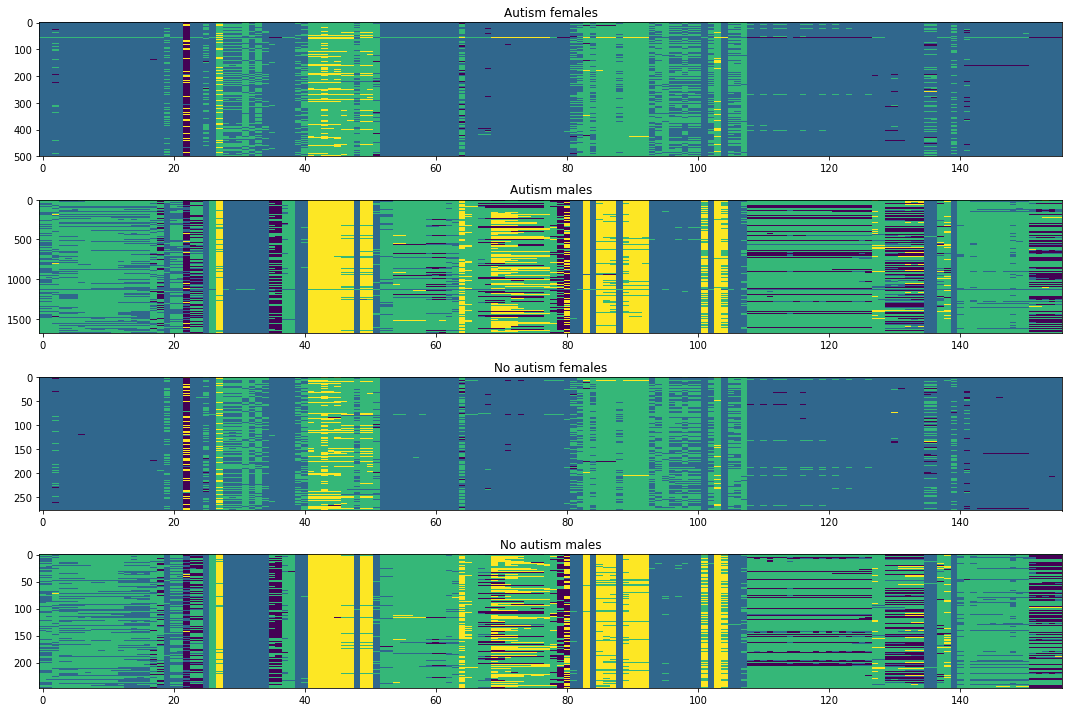

In [261]:
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.imshow(autism_gens_of_interest[list(daughter_indices & autism_indices)], aspect='auto')
plt.title('Autism females')

plt.subplot(4, 1, 2)
plt.imshow(autism_gens_of_interest[list(son_indices & autism_indices)], aspect='auto')
plt.title('Autism males')

plt.subplot(4, 1, 3)
plt.imshow(autism_gens_of_interest[list(daughter_indices & noautism_indices)], aspect='auto')
plt.title('No autism females')

plt.subplot(4, 1, 4)
plt.imshow(autism_gens_of_interest[list(son_indices & noautism_indices)], aspect='auto')
plt.title('No autism males')

plt.tight_layout()
plt.show()

# Look at relationships between categories of family members

In [ ]:
gens = [-1, 0, 1, 2]

mom_dad_pvalues = np.zeros((n, 4), dtype=int)
mom_daughter_pvalues = np.zeros((n, 4), dtype=int)
dad_son_pvalues = np.zeros((n, 4), dtype=int)

for i in range(n):
    for j, gen in enumerate(gens):
        dc = np.asarray([[np.sum(gens_of_interest[list(mom_indices), i]==gen),
                         np.sum(gens_of_interest[list(mom_indices), i]!=gen)], 
                         [np.sum(gens_of_interest[list(dad_indices), i]==gen),
                          np.sum(gens_of_interest[list(dad_indices), i]!=gen)]])
        mom_dad_pvalues[i, j] = calc_pvalue(dc)
        
        dc = np.asarray([[np.sum(gens_of_interest[list(mom_indices), i]==gen),
                         np.sum(gens_of_interest[list(mom_indices), i]!=gen)], 
                         [np.sum(gens_of_interest[list(daughter_indices), i]==gen),
                          np.sum(gens_of_interest[list(daughter_indices), i]!=gen)]])
        mom_daughter_pvalues[i, j] = calc_pvalue(dc)
        
        dc = np.asarray([[np.sum(gens_of_interest[list(dad_indices), i]==gen),
                         np.sum(gens_of_interest[list(dad_indices), i]!=gen)], 
                         [np.sum(gens_of_interest[list(son_indices), i]==gen),
                          np.sum(gens_of_interest[list(son_indices), i]!=gen)]])
        dad_son_pvalues[i, j] = calc_pvalue(dc)


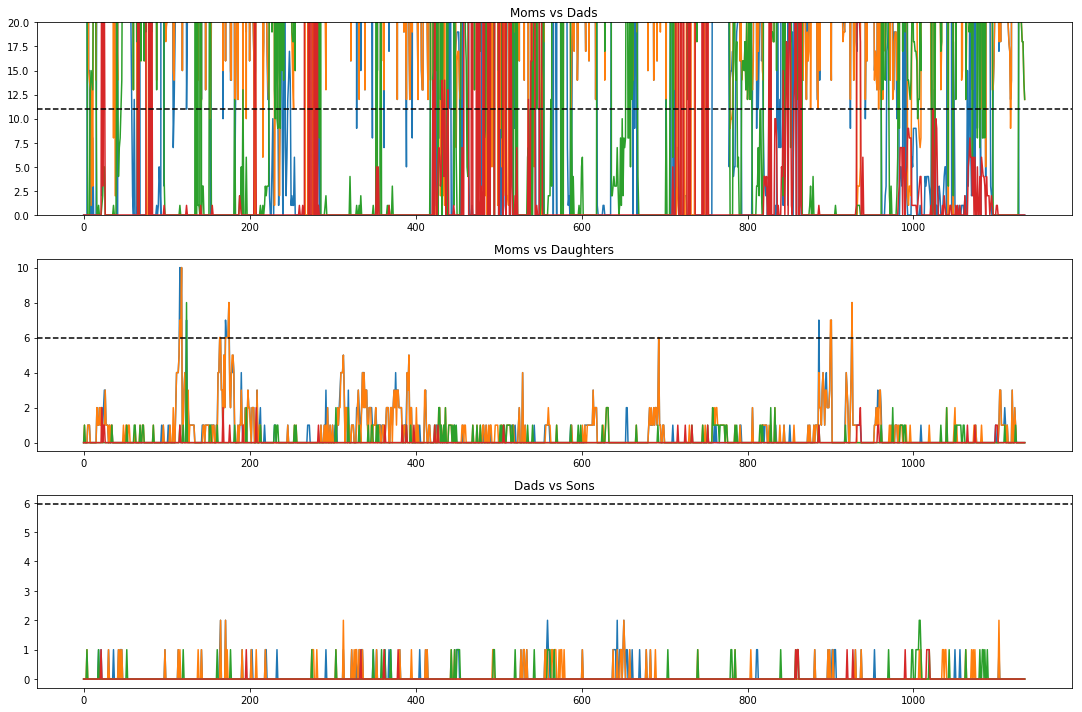

In [212]:
bonferonni_cutoff = 11

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(mom_dad_pvalues)
plt.axhline(bonferonni_cutoff, color='black', linestyle='--')
plt.ylim([0, 20])
plt.title('Moms vs Dads')

plt.subplot(3, 1, 2)
plt.plot(mom_daughter_pvalues)
plt.axhline(-np.log10(0.01/(8*n)), color='black', linestyle='--')
plt.title('Moms vs Daughters')

plt.subplot(3, 1, 3)
plt.plot(dad_son_pvalues)
plt.axhline(-np.log10(0.01/(8*n)), color='black', linestyle='--')
plt.title('Dads vs Sons')

plt.tight_layout()
plt.show()

In [213]:
print(np.sum(mom_dad_pvalues > bonferonni_cutoff, axis=0))
print(list(zip(*np.unique(mom_dad_pvalues > bonferonni_cutoff, axis=0, return_counts=True))))

[ 740 1024  525  102]
[(array([False, False, False,  True]), 3), (array([False, False,  True, False]), 18), (array([False, False,  True,  True]), 37), (array([False,  True, False, False]), 25), (array([False,  True, False,  True]), 3), (array([False,  True,  True, False]), 302), (array([False,  True,  True,  True]), 7), (array([ True, False, False, False]), 24), (array([ True, False, False,  True]), 10), (array([ True, False,  True, False]), 8), (array([ True, False,  True,  True]), 11), (array([ True,  True, False, False]), 536), (array([ True,  True, False,  True]), 9), (array([ True,  True,  True, False]), 120), (array([ True,  True,  True,  True]), 22)]


(4610, 16)


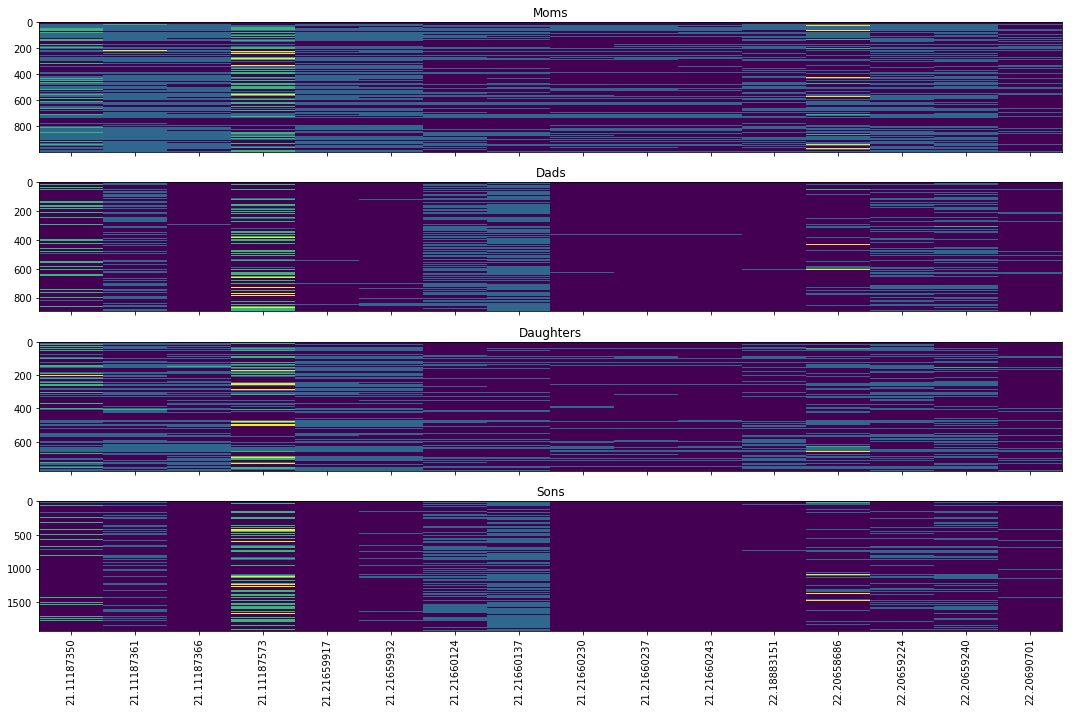

In [217]:
unusual_indices = np.any(mom_daughter_pvalues > -np.log10(0.01/n), axis=1) | np.any(dad_son_pvalues > -np.log10(0.01/n), axis=1)
unusual_gens = gens_of_interest[:, unusual_indices]
print(unusual_gens.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
ax1.imshow(unusual_gens[list(mom_indices)], aspect='auto')
ax1.set_title('Moms')

ax2.imshow(unusual_gens[list(dad_indices)], aspect='auto')
ax2.set_title('Dads')

ax3.imshow(unusual_gens[list(daughter_indices)], aspect='auto')
ax3.set_title('Daughters')

ax4.imshow(unusual_gens[list(son_indices)], aspect='auto')
ax4.set_title('Sons')

plt.xticks(range(unusual_gens.shape[1]), 
           ['%s.%d' % positions_of_interest[i] for i in np.where(unusual_indices)[0]],
          rotation=90)
plt.tight_layout()
plt.show()


In [187]:
for i in np.where(unusual_indices)[0]:
    print(positions_of_interest[i], mom_dad_pvalues[i, :], mom_daughter_pvalues[i, :], dad_son_pvalues[i, :])

('21', 11187350) [90 98  1  0] [10  7  1  1] [0 1 0 0]
('21', 11187361) [30 30  0  0] [6 6 0 0] [0 0 0 0]
('21', 11187366) [233 235   0   0] [10 10  0  0] [0 0 0 0]
('21', 11187573) [11 26  0  1] [7 0 8 0] [0 0 0 0]
('21', 21659917) [180 181   0   0] [6 6 0 0] [1 0 0 0]
('21', 21659932) [135 136   0   0] [6 6 0 0] [2 2 0 0]
('21', 21660124) [16 16  0  0] [7 6 0 0] [2 2 0 0]
('21', 21660137) [57 57  0  0] [6 6 0 0] [0 0 0 0]
('21', 21660230) [62 62  0  0] [6 6 0 0] [0 1 0 0]
('21', 21660237) [61 79  0  0] [6 6 0 0] [0 0 0 0]
('21', 21660243) [83 86  0  0] [8 8 0 0] [0 0 0 0]
('22', 18883151) [97 97  0  0] [6 6 0 0] [0 0 0 0]
('22', 20658686) [51 48  0  1] [7 4 1 1] [0 0 0 0]
('22', 20659224) [25 25  0  0] [6 7 0 0] [0 0 0 0]
('22', 20659240) [14 14  0  0] [7 7 0 0] [0 0 0 0]
('22', 20690701) [27 27  0  0] [8 8 0 0] [0 0 0 0]


In [205]:
gens = [-1, 0, 1, 2]

mom_dad_pvalues = np.zeros((n, 4), dtype=int)
mom_daughter_pvalues = np.zeros((n, 4), dtype=int)
dad_son_pvalues = np.zeros((n, 4), dtype=int)

for i in np.where(unusual_indices)[0]:
    print(positions_of_interest[i])
    
    mom_dad, mom_daughter, mom_son, dad_daughter, dad_son, daughter_son = [], [], [], [], [], []
    for j, gen in enumerate(gens):
        dc = np.asarray([[np.sum(gens_of_interest[list(mom_indices), i]==gen),
                         np.sum(gens_of_interest[list(mom_indices), i]!=gen)], 
                         [np.sum(gens_of_interest[list(dad_indices), i]==gen),
                          np.sum(gens_of_interest[list(dad_indices), i]!=gen)]])
        mom_dad.append(calc_pvalue(dc))
        
        dc = np.asarray([[np.sum(gens_of_interest[list(mom_indices), i]==gen),
                         np.sum(gens_of_interest[list(mom_indices), i]!=gen)], 
                         [np.sum(gens_of_interest[list(daughter_indices), i]==gen),
                          np.sum(gens_of_interest[list(daughter_indices), i]!=gen)]])
        mom_daughter.append(calc_pvalue(dc))
        
        dc = np.asarray([[np.sum(gens_of_interest[list(mom_indices), i]==gen),
                         np.sum(gens_of_interest[list(mom_indices), i]!=gen)], 
                         [np.sum(gens_of_interest[list(son_indices), i]==gen),
                          np.sum(gens_of_interest[list(son_indices), i]!=gen)]])
        mom_son.append(calc_pvalue(dc))
        
        dc = np.asarray([[np.sum(gens_of_interest[list(dad_indices), i]==gen),
                         np.sum(gens_of_interest[list(dad_indices), i]!=gen)], 
                         [np.sum(gens_of_interest[list(daughter_indices), i]==gen),
                          np.sum(gens_of_interest[list(daughter_indices), i]!=gen)]])
        dad_daughter.append(calc_pvalue(dc))
        
        dc = np.asarray([[np.sum(gens_of_interest[list(dad_indices), i]==gen),
                         np.sum(gens_of_interest[list(dad_indices), i]!=gen)], 
                         [np.sum(gens_of_interest[list(son_indices), i]==gen),
                          np.sum(gens_of_interest[list(son_indices), i]!=gen)]])
        dad_son.append(calc_pvalue(dc))
        
        dc = np.asarray([[np.sum(gens_of_interest[list(daughter_indices), i]==gen),
                         np.sum(gens_of_interest[list(daughter_indices), i]!=gen)], 
                         [np.sum(gens_of_interest[list(son_indices), i]==gen),
                          np.sum(gens_of_interest[list(son_indices), i]!=gen)]])
        daughter_son.append(calc_pvalue(dc))
        
    print('Mom-Dad', [int(p) for p in mom_dad])
    print('Mom-Daughter', [int(p) for p in mom_daughter])
    print('Mom-Son', [int(p) for p in mom_son])
    print('Dad-Daughter', [int(p) for p in dad_daughter])
    print('Dad-Son', [int(p) for p in dad_son])
    print('Daughter-Son', [int(p) for p in daughter_son])


('21', 11187350)
Mom-Dad [90, 98, 1, 0]
Mom-Daughter [10, 7, 1, 1]
Mom-Son [136, 159, 4, 0]
Dad-Daughter [38, 58, 0, 1]
Dad-Son [0, 1, 0, 0]
Daughter-Son [56, 87, 0, 1]
('21', 11187361)
Mom-Dad [30, 30, 0, 0]
Mom-Daughter [6, 6, 0, 0]
Mom-Son [46, 46, 0, 0]
Dad-Daughter [8, 8, 0, 0]
Dad-Son [0, 0, 0, 0]
Daughter-Son [13, 13, 0, 0]
('21', 11187366)
Mom-Dad [233, 235, 0, 0]
Mom-Daughter [10, 10, 0, 0]
Mom-Son [1000, 1000, 0, 0]
Dad-Daughter [146, 147, 0, 0]
Dad-Son [0, 0, 0, 0]
Daughter-Son [221, 221, 0, 0]
('21', 11187573)
Mom-Dad [11, 26, 0, 1]
Mom-Daughter [7, 0, 8, 0]
Mom-Son [13, 43, 0, 0]
Dad-Daughter [0, 20, 6, 0]
Dad-Son [0, 0, 0, 0]
Daughter-Son [0, 31, 11, 0]
('21', 21659917)
Mom-Dad [180, 181, 0, 0]
Mom-Daughter [6, 6, 0, 0]
Mom-Son [1000, 1000, 0, 0]
Dad-Daughter [126, 127, 0, 0]
Dad-Son [1, 0, 0, 0]
Daughter-Son [246, 246, 0, 0]
('21', 21659932)
Mom-Dad [135, 136, 0, 0]
Mom-Daughter [6, 6, 0, 0]
Mom-Son [187, 188, 0, 0]
Dad-Daughter [85, 85, 0, 0]
Dad-Son [2, 2, 0, 0]
Daught

In [104]:
print(snps_of_interest[:, np.newaxis].shape)

(974, 1)


In [112]:
A = np.load('../parental_differences_ihart/chr.22.logpvalues.npy')

In [126]:
a = np.zeros((2, 2), dtype=int)
print(a)
a[0, 0] = 1.1
print(a)

[[0 0]
 [0 0]]
[[1 0]
 [0 0]]
